In [1]:
import sys
sys.path.append('../..')
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


from ampligraph.datasets import load_from_csv
from ampligraph.discovery import find_clusters

In [3]:
# International football matches triples
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football.csv'
open('football.csv', 'wb').write(requests.get(url).content)
# Load the data from the csv file
X = load_from_csv('.', 'football.csv', sep=',')[:, 1:]

In [4]:
# Create, compile and fit the model on the data
from ampligraph.latent_features import ScoringBasedEmbeddingModel
model = ScoringBasedEmbeddingModel(eta=5, 
                                 k=300,
                                 scoring_type='ComplEx')



model.compile(optimizer='adam', loss='multiclass_nll')

model.fit(X,
          batch_size=10000,
          epochs=20, 
          verbose=False)



In [5]:
# create a dataframe from the dataset
df = pd.DataFrame(X, columns=["s", "p", "o"])
# find the unique team names in the dataset
teams = np.unique(np.concatenate((df.s[df.s.str.startswith("Team")],
                               df.o[df.o.str.startswith("Team")])))
# get the embeddings for the teams
team_embeddings = model.get_embeddings(teams, embedding_type='e')
# Perform PCA
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings]))

# Find clusters of embeddings using KMeans
kmeans = KMeans(n_clusters=6, n_init=100, max_iter=500)
clusters = find_clusters(teams, model, kmeans, mode='e')

print(np.unique(clusters, return_counts=True))


(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 52, 106,  45,   2,  52,  56]))


In [6]:
import re
from adjustText import adjust_text
import numpy as np
np.random.seed(10)

plot_df = pd.DataFrame({"teams": teams,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

# Top 20 teams in 2022 according to FIFA rankings
top20teams = ["TeamBrazil", "TeamBelgium", "TeamArgentina", "TeamFrance", "TeamEngland", 
              "TeamSpain", "TeamItaly", "TeamNetherlands", "TeamPortugal", "TeamDenmark",
              "TeamGermany", "TeamMexico", "TeamUruguay", "TeamUnitedStates", "TeamCroatia",   
              "TeamSwitzerland",  "TeamColombia", "TeamSenegal", "TeamWales",  "TeamSweden"]



# Plot 2D embeddings
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df,
                         x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02,
                         point['embedding2']+0.01,
                         str(point["teams"])))
    adjust_text(texts)

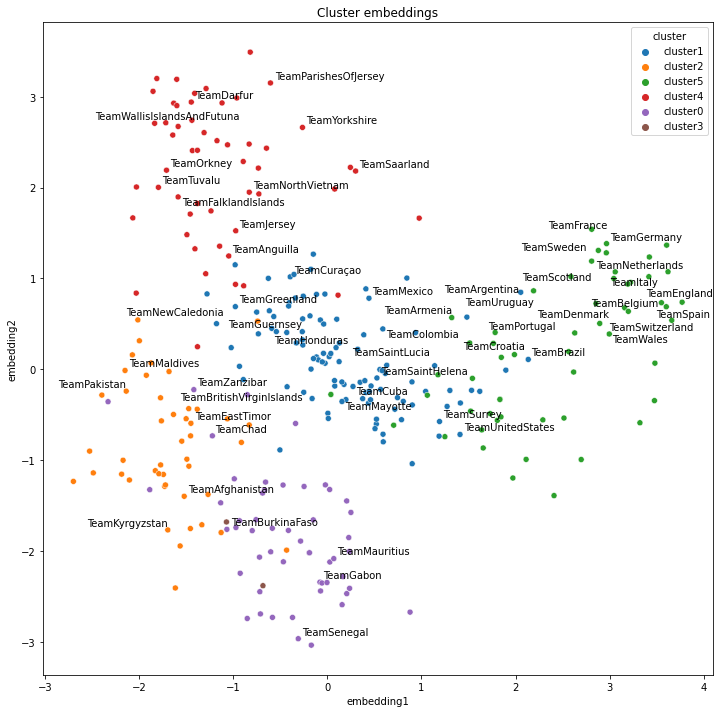

In [7]:
plot_clusters("cluster")